# XGBoosting Algorithm for steel calssification


<br>

This is a protocol on how we built a first XGBoost-Model to classify steel types. It is a hands-on approach based on the labeled_OES_data.csv-File and differs from the final code implemented in our Project. 

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

## 1. Load  and prepare data

In [3]:
# Read labeled_OES_data.csv
data = pd.read_csv("labeled_OES_data.csv")

# convert steel types to numbers
# Note: in our project steel types are not predefined, but will be extracted from the supplied file of data
classes_dict = {"St 48" : 0, "St 37" : 1, "St Si" : 2, "Flussstahl" : 3, "Puddelstahl" : 4}
data["steel_class"] = [classes_dict[c] for c in data["steel_class"] ]    

# make data numeric
for column in data.columns:
        for index, value in data[column].items():
            if isinstance(value, str):
                data.at[index, column] = value.replace(",", ".")
data = data.map(pd.to_numeric)

In [4]:
# create X and y
X = data.drop(columns="steel_class")
y = data["steel_class"]

# create training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<br>

## 2. Build XGBoost

XGBoost (Extreme Gradient Boosting) is an ensemble learning algorithm based on decision trees as weak learners. Each decision tree is created to correct the error of its parent. XGB uses gradient descent to optimize the loss function and regularization to prevent overfitting. In other multi-classification problems XGBoost has proven to be a robust and accurate model, which is why we decided to apply it.

<br>

### XGBoost-Classifier

In the following we go over parameters that are useful in our case:

- **n_estimators** (default = 100): the number of trees to build 
- **learning_rate** (default = 0.1): factor scaling the contribution of each tree. The lower the value the more robust the model (requires higher number of trees though)
- **max_depth** (default = 3): maximum depth of each tree in the ensemble
- **gamma** (default = 0): minimum loss reduction required to make further partition of a leaf node
- **reg_lambda** (default = 1): controls the amount of regularization applied to the weights of the features in each tree
- **objective**: specifies the learning task
- in our case of multi-classification the Classifier needs additionaly **num_classe**: Number of classes that the data need to be categorized in

<br>

To get a first idea how the Algorithm is performing we let it run with only using the nessecary parameters.

In [5]:
# Given are steel types: St48, St 37, StSi, Flussstahl, Puddelstahl -> num_class = 5
# Note: in our Project num_classes is dependent on the supplied file which is used to train the model

# create Classifier
model = xgb.XGBClassifier(objective="multi:softmax", num_class=5)

# train model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

<br>

## 3. Make Prediction

We do our first prediction to get an initial performance.

In [6]:
y_pred = model.predict(X_test)

<br>

We print the result to get a rough idea of the predictions.

In [7]:
results_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(results_df)

     Actual  Predicted
395       0          0
78        0          0
278       2          2
305       0          0
325       2          2
..      ...        ...
57        0          0
137       1          1
24        0          0
17        0          0
66        0          0

[88 rows x 2 columns]


<br>

## 4. Estimate of performance with 9-fold Cross-Validation

<br>

 The least populated class in y has only 9 members, so we do a 9-fold Cross-Validation

In [8]:
from sklearn.model_selection import cross_val_score

In [14]:
score_array = cross_val_score(xgb.XGBClassifier(objective="multi:softmax", num_class=5), X, y, cv=9)
sum(score_array)/len(score_array)

0.9633408919123205

The initial Classifier already has an accuracy of 96.33%, which is already a satisfactory performance.

<br>

## 5. Hyperparameter Optimization

<br>

To improve the performance even further we do a Hyperparameter Optimization, where we figure out other values for the parameters described in the introduction of the XGB-Classifier

In [22]:
# Random parameters that we going to try to get to the best score

test_parameter={
 "n_estimators"     : [100, 200, 500, 1000],
 "learning_rate"    : [0.05, 0.01, 0.1, 1] ,
 "max_depth"        : [2, 3, 4, 5],
 "gamma"            : [0, 0.01, 0.1, 0.3],
 "reg_lambda"       : [0, 1, 10, 20],
}

GridSearch is used to automate the process of tuning parameters. It searches through our test_parameter variable and returns the combination of parameters which returns the best performance.

In [11]:
from sklearn.model_selection import GridSearchCV

In [23]:

gsv = GridSearchCV(
    estimator=xgb.XGBClassifier(objective="multi:softmax", num_class=5), 
    param_grid=test_parameter, scoring="accuracy", cv=9, n_jobs=-1, verbose=0)
gsv.fit(X,y)
print(gsv.best_params_)

{'gamma': 0.1, 'learning_rate': 1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 20}


<br>

## 6. Redo Cross Validation with new XGBClassifier

<br>

To get the final evaluation of our model with the improved parameters we do another cross validation:

In [26]:
score_array = cross_val_score(xgb.XGBClassifier(objective="multi:softmax", num_class=5, n_estimators=100, max_depth=3, learning_rate=1, gamma=0.1, reg_lambda=20), X, y, cv=9)

sum(score_array)/len(score_array)

0.9725056689342403

Thanks to the Hyperparameter Optimization we were able to push the accuracy from 96.33% to 97.25%

<br>

## 7. Further Evaluation of the improved XGB-Classifier

<br>

In [28]:
#build and train new improved xgb model
improved_XGB_model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, n_estimators=100, max_depth=3, learning_rate=1, gamma=0.1, reg_lambda=20)
improved_XGB_model.fit(X_train, y_train)

# make predictions with new model
improved_predictions = improved_XGB_model.predict(X_test)

results_df_imp = pd.DataFrame({"Actual": y_test, "Predicted": improved_predictions})
print(results_df_imp)

     Actual  Predicted
395       0          0
78        0          0
278       2          2
305       0          0
325       2          2
..      ...        ...
57        0          0
137       1          1
24        0          0
17        0          0
66        0          0

[88 rows x 2 columns]


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

<br>

### Confusion Matrix

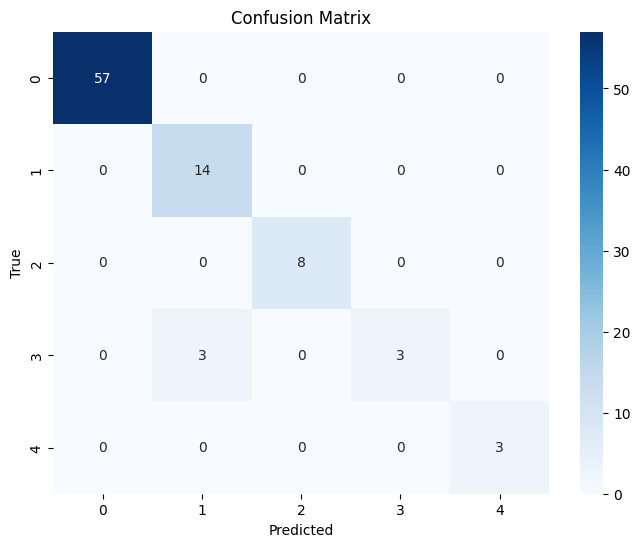

In [34]:
# build Confusion Matrix
conf_matrix = confusion_matrix(improved_predictions, y_pred)

# print Confusion Martix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<br>

From the y-testing data we can see that everything got correctly classified, except 3 instances of the Type 3 (Flussstahl). The model has a hard time classifying Type 3 - Steels and often times classifies them into Type 1 (St 37). This is because the given Dataset only has 9 Instances of Type 3 which is not enough to train the model accodingly for that type. Since more data is not available, this is the best model we can create out of the given ressources. 

<br>

### Classification Report

In [38]:
report = classification_report(y_test, improved_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       0.93      0.81      0.87        16
           2       1.00      1.00      1.00         8
           3       0.83      1.00      0.91         5
           4       1.00      0.60      0.75         5

    accuracy                           0.94        88
   macro avg       0.94      0.88      0.90        88
weighted avg       0.95      0.94      0.94        88



<br>

## 8. Conclusion

<br>

**In this notebook, we successfully implemented and trained an XGBoost model for classifying steel types based on element compositions from steel samples. We followed a structured workflow, including data exploration, preprocessing, model training, Hyperparameter Optimization and further evaluation.**

Key Findings:
- Our XGBoost model achieved a commendable performance in classifying steel types with an accuracy of 97.25%.
- The classification report and confusion matrix provided detailed insights into the model's precision, recall, and overall accuracy for each steel type.
- We observed a lack of Flussstahl-samples during our analysis, which could not be compensated with the given ressources.


<br>